In [1]:
%matplotlib inline
%run ../../import_envs.py
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.1.0 cuda: True


In [2]:
%run PARAMETERS.py
NAME = 'APG'
APG_STEPS = 5 
PATH = NAME + '-bmnist-galileo-%dsamples' % (SAMPLE_SIZE)
CUDA = torch.cuda.is_available()
DEVICE = torch.device('cuda:1')

In [3]:
from model_operations import Init_models, Save_models

models, optimizer, AT = Init_models(K=K,
                                D=D,
                                FRAME_PIXELS=FRAME_PIXELS, 
                                DIGIT_PIXELS=DIGIT_PIXELS, 
                                HIDDEN_LIST=HIDDEN_LIST, 
                                Sigma0=Sigma0,
                                CUDA=CUDA, 
                                DEVICE=DEVICE, 
                                lr=LEARNING_RATE, 
                                RESTORE=True, 
                                PATH=PATH)

mnist_mean = mnist_mean.cuda().to(DEVICE)

In [4]:
from apg import APG
from viz_mc import Viz_MC
from testing import Eval
BATCH_SIZE = 5
Viz_INTERVAL = 1
FS = 15
TITLE_FS = 20
BOUND = 10
DATA_PTR = 23

apg = APG(models=models, 
          AT=AT, 
          K=K, 
          D=D, 
          T=T, 
          mnist_mean=mnist_mean, 
          training=False)

evaluator = Eval(DATA_PATH=data_path,
                 NUM_GROUPS=NUM_GROUPS, 
                 K=K, 
                 D=D)
visualizer = Viz_MC(K=K, 
                    viz_interval=Viz_INTERVAL, 
                    FS=FS, 
                    TITLE_FS=TITLE_FS, 
                    bound=BOUND)


In [5]:

Metrics = evaluator.Test_uniform(APG=apg, 
                                        optimizer=optimizer,
                                        data_ptr=DATA_PTR,
                                        APG_STEPS=APG_STEPS, 
                                        S=1,
                                        B=BATCH_SIZE,
                                        DEVICE=DEVICE,
                                        PATH=PATH)

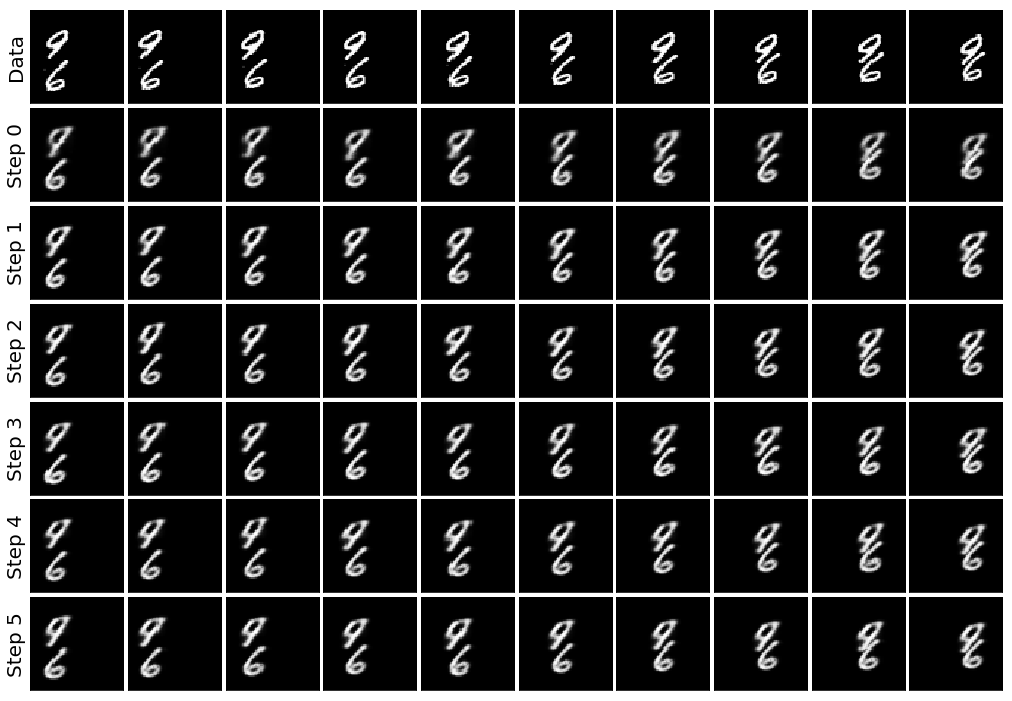

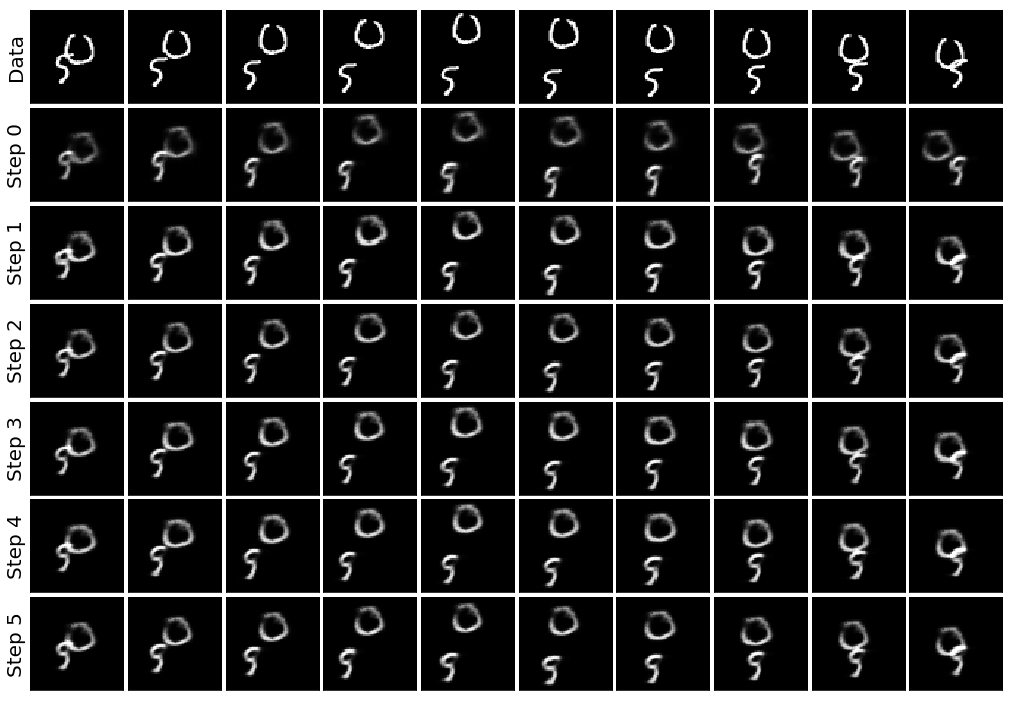

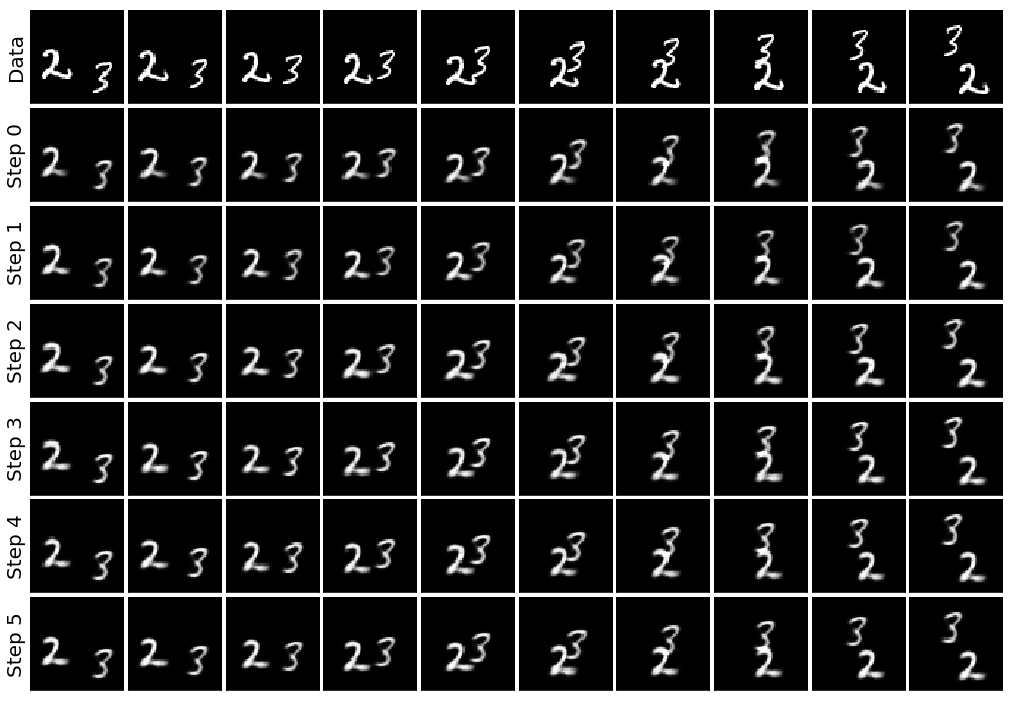

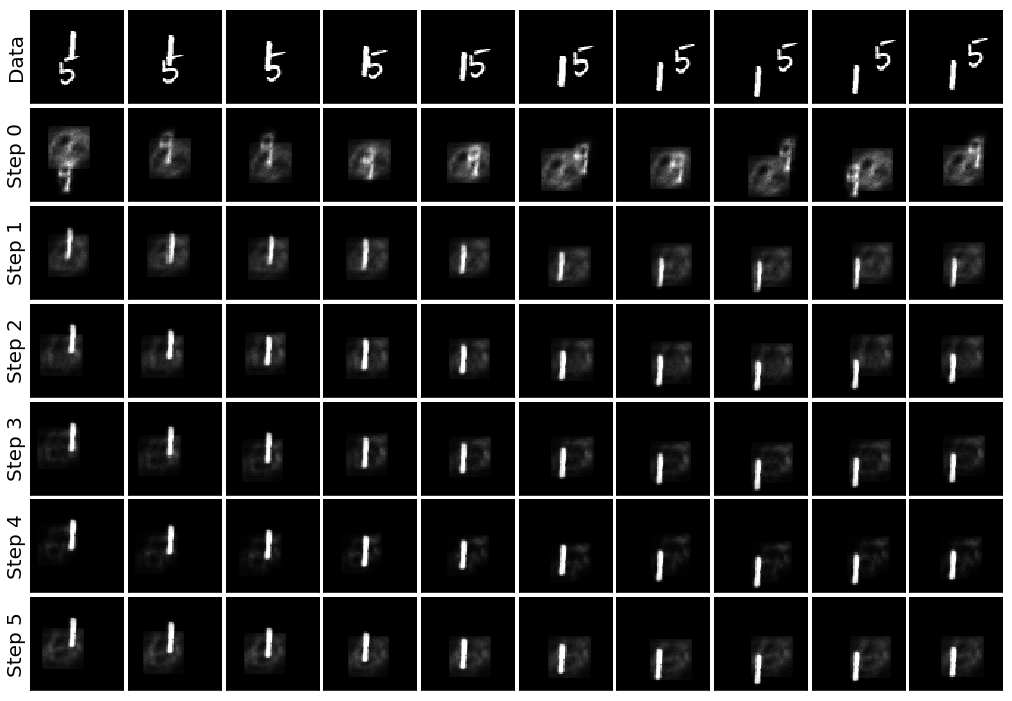

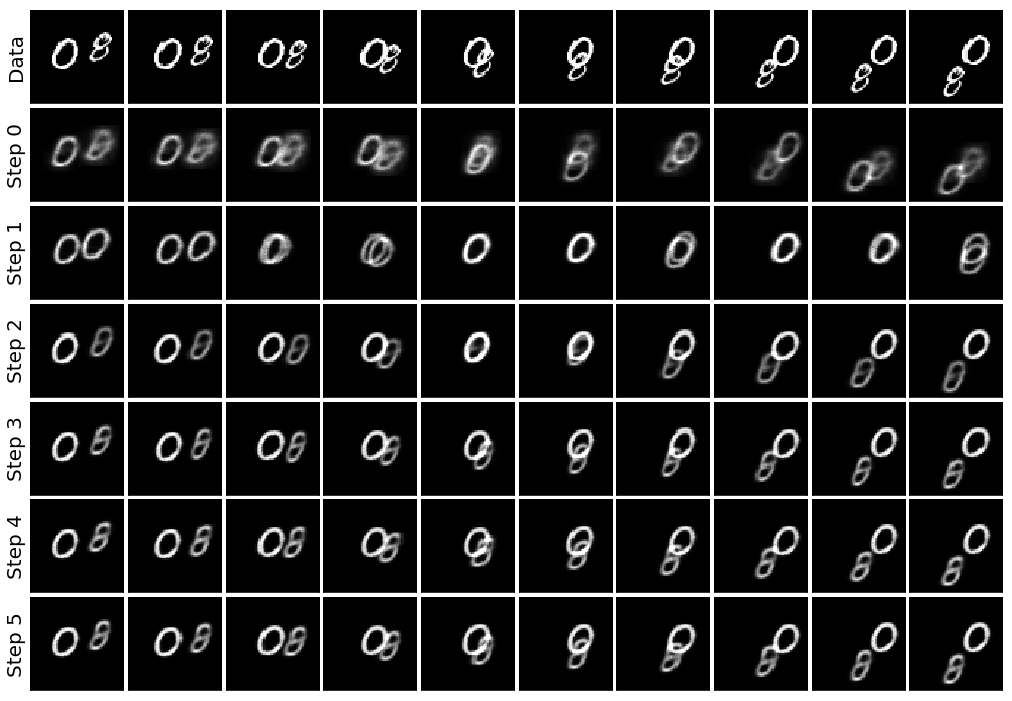

In [6]:
visualizer.Plot_samples(Metrics, filename='bmnist-samples-%d' % DATA_PTR)